## Projeto final de Ciência dos Dados: Classificação de Pokémons a partir da sua cor e... 
----------------------
##### Feito por:
Enrico Aloisi Nardi e Evandro Fontana Romeiro- 2º semestre de engenharia (Insper 2018)


##### Ideia geral do projeto:
A partir do que será apresentado, buscaremos tentar encontrar uma relação explícita entre os stats de um Pokémon, a sua cor e a sua categoria para então prever se existe um agrupamento natural deles mesmo que pertençam a diferentes gerações.

In [67]:
# Imports necessários para o projeto:
import os
import colorsys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from colorthief import ColorThief
from pandas import DataFrame as df
from sklearn import cluster
from pandas import ExcelWriter
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [161]:
data= pd.read_csv('Pokemon.csv') #lendo o database baixado do kaggle 

#O bloco a seguir encontra-se comentado para que o comando criador.save() não interfira nas alterações feitas no excel pelo computador
#transformando o database csv em excel para poder eliminar incongruências entre a base de fotos e a de dados sobre os 
#Pokémons
# criador = ExcelWriter('Pokexcel.xlsx')                         
# data.to_excel(criador,'Sheet5')
# criador.save()

Lendo os dados com o tamanho já acertado para ser compatível com a base de imagens

In [3]:
data_final = pd.read_excel('Pokexcel.xlsx') #lendo os dados já alterados e com o mesmo número de fotos
data_final.head(3)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


Daqui em diante, uma vez que o algoritmo do KMeans não trabalha com strings, foi feita a seguinte mudança do nome da categoria de um Pokémon para um número (a necessidade de repetir números é explicada detalhadamente no relatório no final deste arquivo):

| Categoria primária    | Número equivalente   | Número de pokémons na categoria          
| ------------- |:-------------  |:------------
     | Water    | 0             | 112
     | Normal   | 0             |  98
     | Grass    | 1             |  70
     | Bug      | 1             |  69
     | Psychic  | 2             |  57
     | Fire     | 2             |  52
     | Electric | 2             |  44
     | Rock     | 3             |  44
     | Ghost    | 4             |  32
     | Dragon   | 5             |  32
     | Ground   | 6             |  32
     | Dark     | 6             |  31
     | Poison   | 7             |  28
     | Steel    | 7             |  27
     | Fighting | 8             |  27
     | Ice      | 8             |  24
     | Fairy    | 9             |  17
     | Flying   | 10             |   4

Histograma que permite a visualização geral da distribuição dos pokémons de acordo com o seu tipo principal (Type 1)


In [74]:
plt.hist(data['Type 1'], rwidth= .9, bins= 18);

Extraindo a cor predominante de cada imagem e armazenando-a em listas nos formatos RGB e HSV. Todas as linhas da célula abaixo encontram-se comentados pois ela demora muito para processar as 804 fotos da pasta e os valores necessários já foram guardados nas suas respectivas variáveis.

In [5]:
lis_cores_rgb_f = [] #lista que guardará os códigos RGB das cores predominantes em cada foto

lis_cores_hsv_f = [] #lista que guardará os códigos HSV das cores predominantes em cada foto

path = 'C:/Users/Enrico Aloisi Nardi/Desktop/Insper/SEGUNDO semestre/Ciência dos Dados/Projeto 3/Projeto-3--CDD/pokeimagens/'
arq_na_pasta= os.listdir(path)

for foto in arq_na_pasta:
    color_thief = ColorThief(path + foto)

    #recebendo a cor predominante de cada foto
    cor_predominante_f = color_thief.get_color(quality=1)
    lis_cores_rgb_f.append(cor_predominante_f)
    
    # Colocando a variável "cor predominante" numa função que converte um código de cores RGB em HSV e vice-versa.
    # Ela será utilzada para aumentar a 'precisão' da leitura da cor da foto feita pelo ColouThief, que entrega o resultado em RGB.
    # Com a conversão RGB-HSV buscamos reduzir confusões feitas pelo programa por conta de pequenas diferenças na cor lida.
    cor_predominante_hsv_f = colorsys.rgb_to_hsv(cor_predominante_f[0], cor_predominante_f[1], cor_predominante_f[2])
    
    lis_cores_hsv_f.append(cor_predominante_hsv_f[0] * 360)

Mudando a categoria do Pokémon de texto para número, uma vez que este é o único input aceito pelo algoritmo do KMeans.

In [219]:
data_final['H'] = [x for x in lis_cores_hsv_f]

data_final.loc[data_final['Type 1'] == 'Water'   , "Categoria_Num"] = "0"
data_final.loc[data_final['Type 1'] == 'Ice'     , "Categoria_Num"] = "0"
data_final.loc[data_final['Type 1'] == 'Fighting', "Categoria_Num"] = "1"
data_final.loc[data_final['Type 1'] == 'Normal'  , "Categoria_Num"] = "1"
data_final.loc[data_final['Type 1'] == 'Poison'  , "Categoria_Num"] = "2"
data_final.loc[data_final['Type 1'] == 'Grass'   , "Categoria_Num"] = "2"
data_final.loc[data_final['Type 1'] == 'Bug'     , "Categoria_Num"] = "2"
data_final.loc[data_final['Type 1'] == 'Psychic' , "Categoria_Num"] = "3"
data_final.loc[data_final['Type 1'] == 'Fire'    , "Categoria_Num"] = "4"
data_final.loc[data_final['Type 1'] == 'Electric', "Categoria_Num"] = "5"
data_final.loc[data_final['Type 1'] == 'Ground'  , "Categoria_Num"] = "6"
data_final.loc[data_final['Type 1'] == 'Rock'    , "Categoria_Num"] = "6"
data_final.loc[data_final['Type 1'] == 'Ghost'   , "Categoria_Num"] = "7"
data_final.loc[data_final['Type 1'] == 'Dark'    , "Categoria_Num"] = "7"
data_final.loc[data_final['Type 1'] == 'Dragon'  , "Categoria_Num"] = "8"
data_final.loc[data_final['Type 1'] == 'Flying'  , "Categoria_Num"] = "8"
data_final.loc[data_final['Type 1'] == 'Steel'   , "Categoria_Num"] = "9"
data_final.loc[data_final['Type 1'] == 'Fairy'   , "Categoria_Num"] = "10"

data_f = data_final.drop(['Type 1','Type 2','Legendary','Name','#'], axis= 1)
data_f2 = data_f.copy() #criando uma cópia que será posteriormente utilizada
data_f2.head(3)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Categoria_Num
0,318,45,49,49,65,65,45,1,152.000000,2
1,405,60,62,63,80,80,60,1,97.941176,2
2,525,80,82,83,100,100,80,1,349.230769,2


DataFrame com a correlação entre todos os dados numéricos presentes no data frame utilizado nos algoritmos do KMeans e do GMM

In [220]:
data_f.corr(method='pearson') 

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H
Total,1.000000,0.617931,0.736507,0.614463,0.747936,0.716707,0.573981,0.047851,0.020565
HP,0.617931,1.000000,0.420774,0.239522,0.361849,0.378842,0.173738,0.064289,-0.025936
Attack,0.736507,0.420774,1.000000,0.439595,0.396526,0.262304,0.383306,0.048854,0.024716
Defense,0.614463,0.239522,0.439595,1.000000,0.229778,0.512272,0.015133,0.029015,0.046739
Sp. Atk,0.747936,0.361849,0.396526,0.229778,1.000000,0.507014,0.467620,0.039584,0.001992
Sp. Def,0.716707,0.378842,0.262304,0.512272,0.507014,1.000000,0.254668,0.030432,-0.010665
Speed,0.573981,0.173738,0.383306,0.015133,0.467620,0.254668,1.000000,-0.018409,0.038018
Generation,0.047851,0.064289,0.048854,0.029015,0.039584,0.030432,-0.018409,1.000000,-0.015437
H,0.020565,-0.025936,0.024716,0.046739,0.001992,-0.010665,0.038018,-0.015437,1.000000


## Clusterizando com o KMeans

In [236]:
KM= KMeans(n_clusters= 10, init= 'k-means++', n_init= 50, max_iter= 500) #o número de clusters foi definido a partir do número de dados categorias diferentes de Pokémons
KM.fit(data_f)
y_pred = KM.predict(data_f) #lista que guarda qual é o cluster ao qual pertence cada um dos pokémons
plt.hist(y_pred, rwidth=.9, bins= 10);

In [237]:
data_f["Cluster_KM"]= y_pred #adicionando ao dataframe o cluster atribuído a cada pokémon via KMeans
data_f.head(3)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Categoria_Num,Cluster_KM
0,318,45,49,49,65,65,45,1,152.000000,2,7
1,405,60,62,63,80,80,60,1,97.941176,2,0
2,525,80,82,83,100,100,80,1,349.230769,2,4


In [238]:
# pd.scatter_matrix(data_f, alpha = 1, figsize=(20,20));
# plt.figure(figsize=(12,12))

<IPython.core.display.Javascript object>


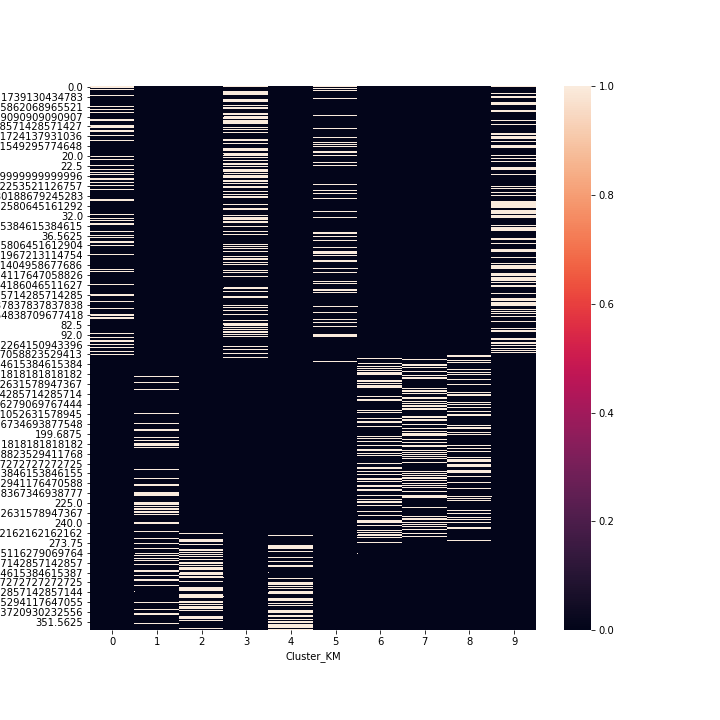

In [267]:
#Utilizar o heatmap para visualizar como os dados foram alocados pelo KMeans é de grande utilidade pois ele nos permite retomar 
# a nossa pergunta inicial constantemente. Ou seja, como desejamos tentar encontrar um agrupamento natural para os Pokémons dada
# u;ma série de características, e considerando a organização apresentada no heatmap abaixo, sabemos que buscamos colunas com
# pontos de concentração
plt.figure(figsize=(10,10))
sns.heatmap(pd.crosstab(data_f["H"],data_f["Cluster_KM"]), robust= True);

<IPython.core.display.Javascript object>


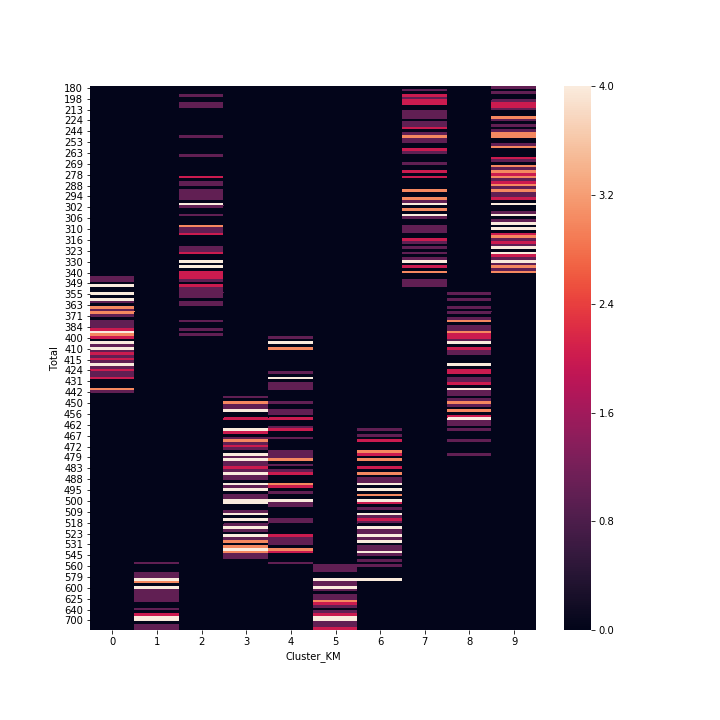

In [278]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.crosstab(data_f["Total"], data_f["Cluster_KM"]), robust= True);

<IPython.core.display.Javascript object>


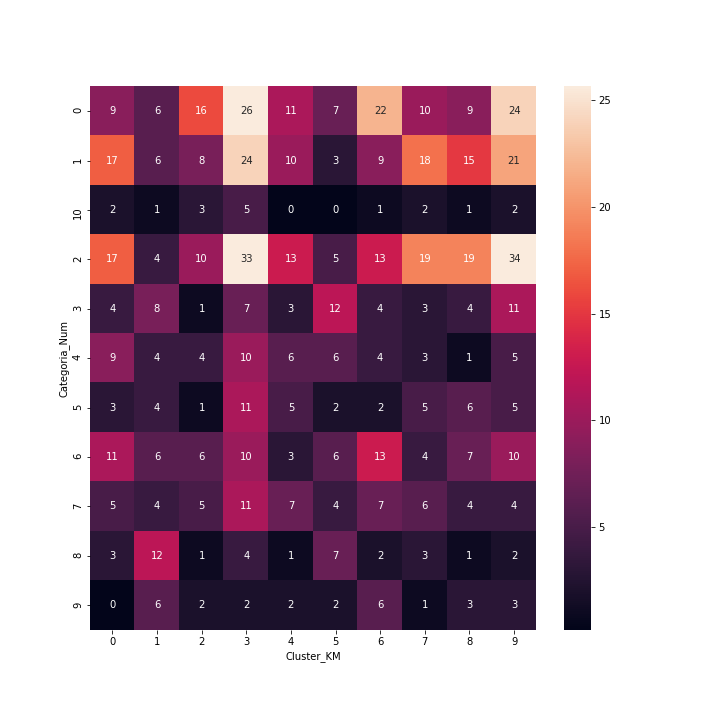

In [279]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.crosstab(data_f["Categoria_Num"],data_f["Cluster_KM"]), annot= True, robust= True);

In [241]:
#separando os pokémons a partir do cluster no qual eles foram colocados pelo algoritmo do KMeans
c0_KM  = data_f.loc[data_f["Cluster_KM"]  ==  0 ]
c1_KM  = data_f.loc[data_f["Cluster_KM"]  ==  1 ]
c2_KM  = data_f.loc[data_f["Cluster_KM"]  ==  2 ]
c3_KM  = data_f.loc[data_f["Cluster_KM"]  ==  3 ]
c4_KM  = data_f.loc[data_f["Cluster_KM"]  ==  4 ]
c5_KM  = data_f.loc[data_f["Cluster_KM"]  ==  5 ]
c6_KM  = data_f.loc[data_f["Cluster_KM"]  ==  6 ]
c7_KM  = data_f.loc[data_f["Cluster_KM"]  ==  7 ]
c8_KM  = data_f.loc[data_f["Cluster_KM"]  ==  8 ]
c9_KM  = data_f.loc[data_f["Cluster_KM"]  ==  9 ]

<IPython.core.display.Javascript object>


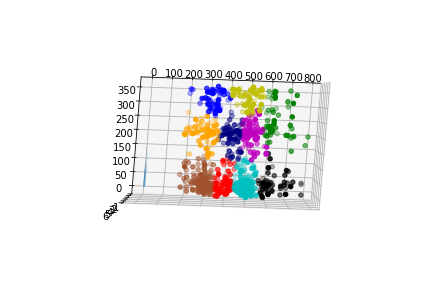

In [280]:
%matplotlib notebook

plt3d = plt.figure().gca(projection="3d")
plt3d.scatter(c0_KM.Total, c0_KM.H, c0_KM.Generation, color="r")
plt3d.scatter(c1_KM.Total, c1_KM.H, c1_KM.Generation, color="g")
plt3d.scatter(c2_KM.Total, c2_KM.H, c2_KM.Generation, color="b")
plt3d.scatter(c3_KM.Total, c3_KM.H, c3_KM.Generation, color="c")
plt3d.scatter(c4_KM.Total, c4_KM.H, c4_KM.Generation, color="y")
plt3d.scatter(c5_KM.Total, c5_KM.H, c5_KM.Generation, color="k")
plt3d.scatter(c6_KM.Total, c6_KM.H, c6_KM.Generation, color="m")
plt3d.scatter(c7_KM.Total, c7_KM.H, c7_KM.Generation, color="orange")
plt3d.scatter(c8_KM.Total, c8_KM.H, c8_KM.Generation, color="navy")
plt3d.scatter(c9_KM.Total, c9_KM.H, c9_KM.Generation, color="sienna")

## Clusterizando com a Gaussian Mixture

In [291]:
GMM = GaussianMixture(n_components= 10, covariance_type= 'spherical')

GMM.fit(data_f2.sample(frac= 1)
)
thirdtry = GMM.predict(data_f2) #lista que guarda qual é o cluster ao qual pertence cada um dos pokémons
plt.hist(y_pred, rwidth=.9, bins= 10);

data_f2["Cluster_GMM"]= thirdtry #adicionando ao dataframe o cluster atribuído a cada pokémon via GMM
data_f.head(3)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Categoria_Num,Cluster_KM
0,318,45,49,49,65,65,45,1,152.000000,2,7
1,405,60,62,63,80,80,60,1,97.941176,2,0
2,525,80,82,83,100,100,80,1,349.230769,2,4


<IPython.core.display.Javascript object>


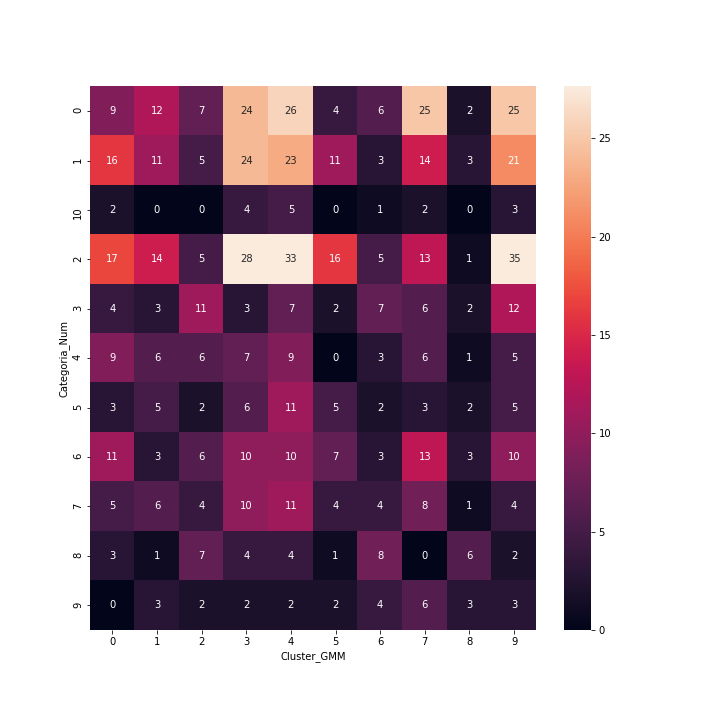

In [292]:
%notebook inline
plt.figure(figsize=(10,10))
sns.heatmap(pd.crosstab(data_f2["Categoria_Num"],data_f2["Cluster_GMM"]), annot=True, robust= True);

<IPython.core.display.Javascript object>


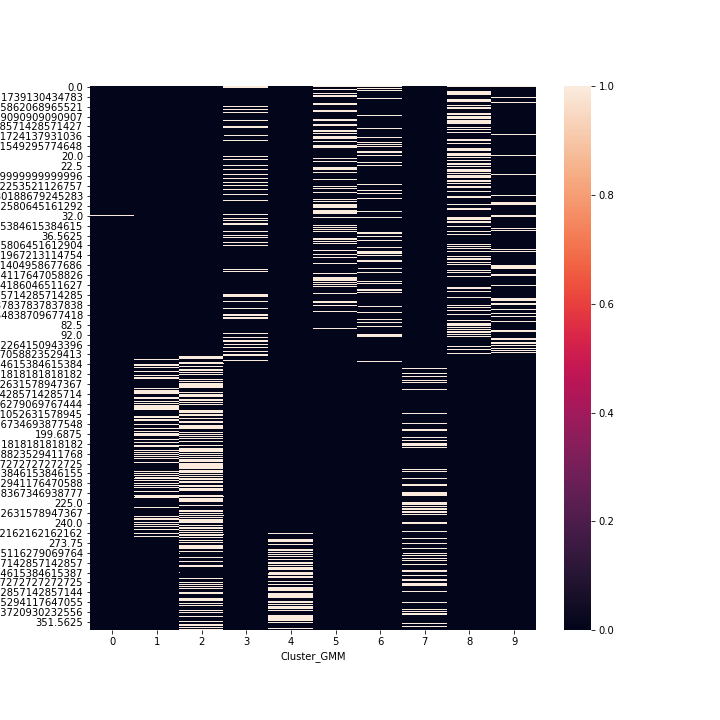

In [289]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.crosstab(data_f2["H"],data_f2["Cluster_GMM"]), robust= True);

<IPython.core.display.Javascript object>


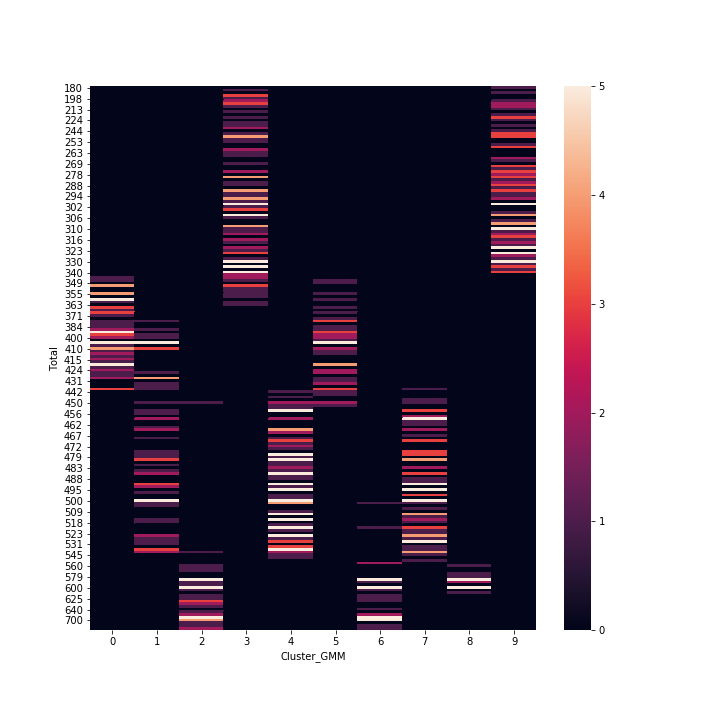

In [293]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.crosstab(data_f2["Total"], data_f2["Cluster_GMM"]), robust= True);

Separando os pokémons a partir do cluster no qual eles foram colocados pelo algoritmo do Gaussian Mixture.

In [294]:
# c0_GMM  = data_f.drop("Cluster_KM", axis= 1)

c0_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  0 ]
c1_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  1 ]
c2_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  2 ]
c3_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  3 ]
c4_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  4 ]
c5_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  5 ]
c6_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  6 ]
c7_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  7 ]
c8_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  8 ]
c9_GMM  = data_f2.loc[data_f2["Cluster_GMM"]  ==  9 ]

<IPython.core.display.Javascript object>


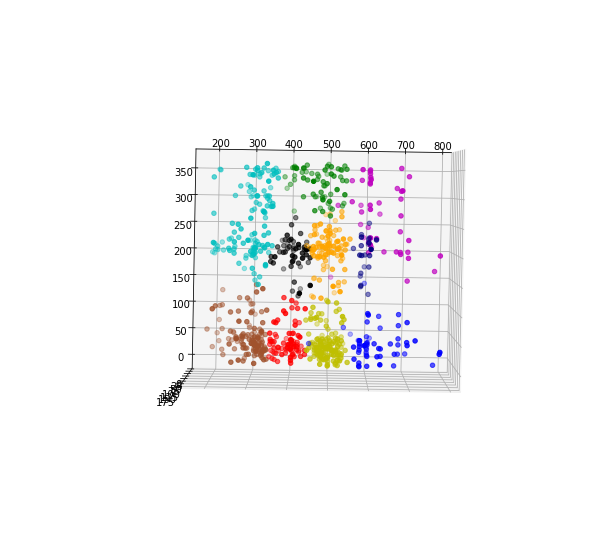

In [295]:
%matplotlib notebook

plt3d = plt.figure().gca(projection="3d");
plt3d.scatter(c0_GMM.Total, c0_GMM.H, c0_GMM.Speed, color="r");
plt3d.scatter(c1_GMM.Total, c1_GMM.H, c1_GMM.Speed, color="g");
plt3d.scatter(c2_GMM.Total, c2_GMM.H, c2_GMM.Speed, color="b");
plt3d.scatter(c3_GMM.Total, c3_GMM.H, c3_GMM.Speed, color="c");
plt3d.scatter(c4_GMM.Total, c4_GMM.H, c4_GMM.Speed, color="y");
plt3d.scatter(c5_GMM.Total, c5_GMM.H, c5_GMM.Speed, color="k");
plt3d.scatter(c6_GMM.Total, c6_GMM.H, c6_GMM.Speed, color="m");
plt3d.scatter(c7_GMM.Total, c7_GMM.H, c7_GMM.Speed, color="orange");
plt3d.scatter(c8_GMM.Total, c8_GMM.H, c8_GMM.Speed, color="navy");
plt3d.scatter(c9_GMM.Total, c9_GMM.H, c9_GMM.Speed, color="sienna");

# TESTES

# Relatório do projeto (em andamento)
------------
## Objetivos
Os objetivos do presente trabalho foram divididos em duas frentes principais, sendo a primeira a de utilizar métodos diferente de agrupamento computacional e a segunda a de verifcar se a classificação dos Pokémons dada pela Nintendo é verifica/semelhante pelo agrupamentos naturais dada pelos clusters com base na cor predominante dos pokémons, seus status (Health Points, Attack, Defence, Special Attack, Special Defence e Speed) e outros fatores.
### Procedimentos realizados com as bases de dados (imagens + stats)

##### Imagens
Inicialmente, as imagens dos Pokémons são vetorizadas para que a função ColourThief possa extrair a cor predominante de cada uma delas. Neste ponto é importante notar que como a extensão das imagens dos Pokémons é .png, elas não têm fundo, ou seja, a cor extraída pela função não é afetada por um eventual fundo branco. Deste modo, obtivemos a seguinte transformação:

<img src="pokeimagens/1.png"> ------->  cor predominante no código RGB (120, 180, 152) -------> cor predominante no código HSV (152, 33, 71)-------> <img src="verde.png">

##### Stats
Embora tenham sido feitos vários testes com e sem algumas colunas dos dados originais -como inclusive será investigado em seções futuras do relatório-, algumas colunas não foram utilizadas em nenhum momento da análise, tais como Name, Type 2, Legendary e '#', que indica o número de identificação de cada Pokémon. Dentre as colunas não utilizadas, a única que teria potencial de efetivamente influenciar a clusterização seria a do número de referência de cada um, pois, uma vez que existe uma sequência pré determinada para a colocação dos Pokémons no começo de cada temporada (todas começam com duas ou três evoluções de Pokémons de planta, fogo e água), o cluster obtido já teria sido quase previamente informado para o algoritmo.


### Métodos de análise utilizados
#### Explicando o K-means
O KMeans é um algoritmo de agrupamento versátil e é o mais recomendado para dados com quantidade inferior a 10 mil. 

No exemplo que acompanhará este relatório, teremos três clusters identificados intuitivamente por meio da sua proximidade, como será apresentado a seguir.

<img src="separacaoinicial.png">

Originalmente, o KMeans recebe como argumentos uma série de dados exclusivamente numéricos e o número de clusters a serem encontrados.
A partir destes únicos dois argumentos, começam a ser calculadas as distâncias entre centros artificiais dentro dos limites dos dados (centros estes que recebem o nome de centróides) e os pontos onde se localizam estes dados. Esta frase pode ser elucidada pela foto abaixo: 

<img src="KM_distancias.png">


Calculadas as distâncias entre estas sementes e todos os pontos dos dados, são atribuídos clusters a cada um dos pontos, sendo estas atribuições feitas através da escolha da menor distância entre o ponto e o cluster, gerando o que temos na imagem abaixo. 

<img src="KM_clusters.png">

Porém, antes que os clusters sejam efetivamente escolhidos, são calculadas as distâncias médias entre os pontos dos primeiros clusters e se alguma das distâncias entre a média do cluster e o centroide artificial for menor do que a distância anterior é feita uma reatribuição de cluster.

<img src= "novasdistancias.png">

Note-se que a distância calculada é a Euclidiana, ou seja, em duas dimensões ela é uma distância simples, mas em dimensões maiores, ela é calculada a partir da raiz da soma dos quadrados das distâncias simples (como no caso do programa apresentado tivemos 8 variáveis, foi calculada esta distância em 8 dimensões, o que embora não possua significado gráfico, possui significado matemático).


No caso do nosso algoritmo, foram passados também os seguintes parâmetros extras: (note-se que todas as escolhas a seguir foram feitas em detrimento do pequeno número de dados disponíveis. Ou seja, consideramos que quanto mais vezes o algoritmo rodasse e comparasse as suas diferentes respostas, melhor e mais preciso ele seria.)

n_init = 50 --> número de vezes que o algoritmo cria centros iniciais diferentes para calcular as distâncias mencionadas.

max_iter = 500 --> número de vezes que o algoritmo rodará.


Parâmetros que nos permitiam indicar manualmente, por exemplo, o centro de uma 'semente', foram desconsiderados pois o a função do scikit já faz isso automaticamente a fim de aumentar a velocidade do algoritmo.

#### Explicando o Gaussian Mixture
Partindo de uma dispersão com todos os dados disponíveis em um dataframe, o algoritmo do Gaussian Mixture busca clusters naturais via kmeans (o que é determinado pelo argumento "init_params = kmeans") e os organiza como se fossem distribuições normais, tendo, portanto, médias e desvios padrão diferentes em cada situação.

No momento seguinte a estas atribuições, as distribuições são posicionadas lado a lado a fim de definir qual dado pertence a qual cluster, sendo que quando um dado tem 'potencial' para fazer parte de dois clusters ao memso tempo, o algoritmo calcula a probabilidade de ele estar em cada um e seleciona a maior para efetivemante agrupar o dado.

No caso do nosso algoritmo, foi passado também o argumento "covariance_type = spherical", que faz com que cada um dos dados tenha a sua própria variância dentro da distribuição normal assumida para cada cluster identificado no primeiro momento de aplicação do GMM, ao invés de cada um dos pontos ter uma matriz de covariância própria. 

#### Comparação entre o KMeans e o Gaussian Mixture
Diferentemente do K-means, o GMM tem mais flexibilidade "nas bordas" do cluster, não se limitando apenas a regiões circulares. Enquanto o K-means utiliza apenas a distância euclidiana entre pontos para definir um cluster, delimitando uma região circular (esferica, para 3 dimensões, ou hiper-esferica, para mais de 3 dimensões), o GMM utiliza da covariancia entre os dados para definir formas elípticas de agrupamentos.
O GMM também calcula a probablidade de cada ponto estar em cada cluster, dessa forma é possível saber a incerteza de um ponto que está em uma região intermediária entre dois clusters.

<img src="K-means_grafico.jpeg" align="left"> <img src="GMM_grafico.jpeg" align="right">



### Verificando a qualidade do agrupamento em diferentes cenários

#### Código de cores: RGB vs. HSV
A diferença entre a performance do algoritmo ao considerar os dois códigos de cores decorre do fato de o código RGB precisar de três coordenadas para definir uma única cor, ao passo que dentre os componentes do HSV apenas o H é suficiente para realizar essa tarefa, visto que o brilho (V) e a saturação (S) não são necessários. Além disso, a quantidade de dados era substancialmente maior no sistema RGB, o que acabou deixando os clusters com uma disparidade muito grande entre os seus elementos, isso foi consertado através do uso do sistema HSV e de outras escolhas a serem mencionadas.

#### Com stats e sem stats
Os Stats dos Pokémons aparentaram ter se tornado os maiores suporte do algoritmo, uma vez que em todos os momentos havia alguma relação entre os clusters encontrados pelo algoritmo. Desta forma, como a não utilização destas características empobrecia a amostra de dados e diminuia a precisão do que os clusters nos mostravam, optamos por mantê-las para a realização da análise final.

#### Com 10 e 18 categorias
Notamos que ao utilizar as 18 categorias propostas pela Nintendo, existia uma ligeira tendência em agrupar os pokémons por meio do seu stat "Total", porém como tínhamos poucos elementos por cluster, não pudemos tirar conclusões demasiadamente assertivas. Entretanto, esta tendência demonstrou-se muito mais forte ao considerarmos apenas 10 categorias (a mesclagem foi feita de modo a juntar categorias semelhantes, como grama e inseto, água e gelo etc)

#### Com geração e sem geração
Pudemos notar que não há relação direta entre a geração dos Pokémons e o cluster atribuído a eles uma vez que o os clusters são mantidos em todas a gerações, como é possível ver na imagem abaixo.

<img src="3dgeracao.png">


## Conclusão

##### Fontes:
CSV com dados sobre os Pokémons: https://www.kaggle.com/abcsds/pokemon

Database de fotos: https://www.kaggle.com/kvpratama/pokemon-images-dataset

Fotos do tópico: 'Explicando o K-means': https://www.youtube.com/watch?v=4b5d3muPQmA